<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_training_vgg16_bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [0]:
import os
import time
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import shutil

In [2]:
%%time
!git clone -l -s git://github.com/kavyajeetbora/EAST.git cloned-repo
%cd cloned-repo
!ls

rm: cannot remove 'cloned-repo': No such file or directory
Cloning into 'cloned-repo'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 145 (delta 34), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (145/145), 6.20 MiB | 11.42 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/cloned-repo
dataset.py		    EAST_resnet.py		  model.py
detect.py		    EAST_training.ipynb		  model_resnet.py
dsiplay_ground_truth.ipynb  EAST_training_vgg16_bn.ipynb  train.py
EAST_detection.ipynb	    loss.py
CPU times: user 235 ms, sys: 43.9 ms, total: 278 ms
Wall time: 20.1 s


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from dataset import *

In [9]:
# AI4Bharat dataset
image_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Training Set/Image/images_1'
label_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Training Set/Annotation/labels_1'

print('Total image files',len(os.listdir(image_address)))
print('Total annotation files',len(os.listdir(label_address)))

training_dataset = custom_dataset(image_address, label_address)
print(len(training_dataset))

Total image files 4703
Total annotation files 4703
4703


## Dataset Initial Check

In [10]:
img = Image.open(image_address+'/0.jpg')

with open(label_address+'/0.txt', 'r') as f:
			lines = f.readlines()
vertices, labels = extract_vertices(lines)

img, vertices = adjust_height(img, vertices) 
img, vertices = rotate_img(img, vertices)
img, vertices = crop_img(img, vertices, labels, 512)

for vertice in vertices:
  print(vertice)
  print('-'*20)
  
print(labels)

[-141.05430886  128.71837537  -63.00099689  100.2449327   -48.16259233
  138.05604054 -126.2159043   166.5294832 ]
--------------------
[ 79.83400845 337.85555993 263.08197144 336.99131818 264.91997048
 467.7335065   80.45611464 469.82545331]
--------------------
[504.83151845  47.46610153 547.68154036  66.81554044 501.66770029
 153.79246715 458.81191813 133.22108479]
--------------------
[176.69645876 152.88116894 220.80845546 180.77845044 209.89422107
 197.93751335 164.55481105 168.82405   ]
--------------------
[-122.34933655  209.28021937   40.12476373  207.29198157   41.84755791
  313.59530074 -120.63230261  314.36159509]
--------------------
[-117.76273849  404.77388771   66.70111735  402.68194089   68.36630911
  496.76582549 -117.31919981  498.86353392]
--------------------
[-162.80789447  178.92176613 -104.26647044  157.87216999  -94.37804089
  182.26494625 -154.14687826  202.09836053]
--------------------
[259.76886865 152.48937935 466.2167198  149.07178006 466.53929338
 217.5

In [11]:
score_map, geo_map, ignored_map = get_score_geo(img, vertices, labels, 0.25, 512)

torch.sum(score_map)

tensor(1350.)

## Loss for one batch

In [12]:
%%time
train_loader = DataLoader(training_dataset, shuffle = True, batch_size=8)

imgs, gt_score, gt_geo, ignored_maps = next(iter(train_loader))

print(imgs.size(), gt_score.size(), gt_geo.size(), ignored_maps.size())

print(torch.sum(gt_score))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128]) torch.Size([8, 1, 128, 128])
tensor(2836.)
CPU times: user 4.42 s, sys: 4.01 s, total: 8.44 s
Wall time: 8.47 s


In [13]:
%%time

from model import EAST
model = EAST()
pred_score, pred_geo = model(imgs)

print(pred_score.size(), pred_geo.size())

Downloading: "http://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 96.7MB/s]


torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128])
CPU times: user 28.2 s, sys: 4.16 s, total: 32.4 s
Wall time: 22.8 s


In [14]:
from loss import Loss

loss_fn = Loss()

loss_fn(gt_score, pred_score, gt_geo, pred_geo, ignored_maps)

classify loss is 0.96394122, angle loss is 0.75673205, iou loss is 3.65231252


tensor(12.1836, grad_fn=<AddBackward0>)

## Training Full Batch 

fine tuning pretrained model [east_vgg16.pth](https://drive.google.com/file/d/1AFABkJgr5VtxWnmBU3XcfLJvpZkC2TAg/view)

In [0]:
model = EAST()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_path = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/model_2_11_19.pth'
state_dict = torch.load(pretrained_path)
model.load_state_dict(state_dict)
model = model.to(device)

In [0]:
def train(model, train_img_path, train_gt_path, batch_size, lr, epoch_iter, num_workers=4, interval=1):
    file_num = len(os.listdir(train_img_path))
    print(file_num)
    trainset = custom_dataset(train_img_path, train_gt_path)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, \
                                   shuffle=True, num_workers=num_workers, drop_last=True)
	
    criterion = Loss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=epoch_iter, gamma=0.1)
    loss_curve = []
    
    for epoch in range(epoch_iter):
      model.train()
      #scheduler.step()
      epoch_loss = 0
      epoch_time = time.time()
      for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
        start_time = time.time()
        img, gt_score, gt_geo, ignored_map = img.to(device), gt_score.to(device), gt_geo.to(device), ignored_map.to(device)
        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}'.format(\
                  epoch+1, epoch_iter, i+1, int(file_num/batch_size), time.time()-start_time, loss.item()))
        
      print('epoch_loss is {:.8f}, epoch_time is {:.8f}'.format(epoch_loss/int(file_num/batch_size), time.time()-epoch_time))
      print(time.asctime(time.localtime(time.time())))
      print('='*50)
      
      
      if (epoch + 1) % interval == 0:
        state_dict = model.state_dict()
        torch.save(state_dict, 'model_epoch_{}.pth'.format(epoch+1))
      
      ## plotting the loss curve
      loss_curve.append(epoch_loss/int(file_num/batch_size))
    return loss_curve

In [17]:
%%time
loss_curve = train(model, image_address, label_address, batch_size=12, lr=1e-4, epoch_iter=10, interval = 1)

4703
classify loss is 0.42792857, angle loss is 0.03903997, iou loss is 0.87227803
Epoch is [1/10], mini-batch is [1/391], time consumption is 1.92308927, batch_loss is 1.69060636
classify loss is 0.42620158, angle loss is 0.02908878, iou loss is 0.64178795
Epoch is [1/10], mini-batch is [2/391], time consumption is 1.10341549, batch_loss is 1.35887742
classify loss is 0.45833081, angle loss is 0.02270984, iou loss is 0.61133045
Epoch is [1/10], mini-batch is [3/391], time consumption is 0.93384504, batch_loss is 1.29675961
classify loss is 0.50766385, angle loss is 0.03214320, iou loss is 0.77887207
Epoch is [1/10], mini-batch is [4/391], time consumption is 0.95613170, batch_loss is 1.60796797
classify loss is 0.59323871, angle loss is 0.02120313, iou loss is 1.41640246
Epoch is [1/10], mini-batch is [5/391], time consumption is 1.08895469, batch_loss is 2.22167253
classify loss is 0.34222054, angle loss is 0.01915206, iou loss is 0.44503433
Epoch is [1/10], mini-batch is [6/391], ti

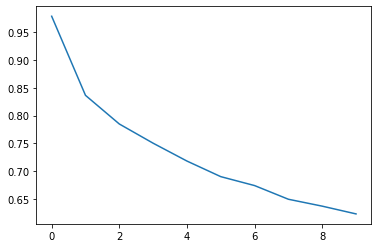

In [18]:
plt.plot(loss_curve)

[Adam and AdamW algorithms](https://www.fast.ai/2018/07/02/adam-weight-decay/)